In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import numpy as np
import pandas as pd
import sys
import re
import concurrent.futures
import tqdm
import multiprocessing
from functools import partial
import pickle

sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D
from CHARMtools import spatialstat

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

/tmp/ipykernel_1724990/3266015118.py:32: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [3]:
# load metadata
metadata = pd.read_csv('../data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2].reset_index(drop=True)
metadata["cellnext"] = metadata["cellname"].sample(frac=1,random_state=42).values
metadata = metadata.reset_index(drop=True)

# load RNA data
rnag1 = pd.read_csv("../data/RNAmats/counts.gene.genome1.format.tsv.gz",sep='\t')
rnag2 = pd.read_csv("../data/RNAmats/counts.gene.genome2.format.tsv.gz",sep='\t')
genes = pd.read_csv("./transcripts.bed",sep='\t',header=None)
genes.columns = ["chrom","start","end","name","strand"]
genes["ids"] = "."
genes = genes[["chrom","start","end","ids","name","strand"]]
chroms = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9",
            "chr10","chr11","chr12","chr13","chr14","chr15","chr16",
            "chr17","chr18","chr19","chrX"]
genes = genes[genes["chrom"].isin(chroms)].reset_index(drop=True)
rnamerge = rnag1.set_index("gene") + rnag2.set_index("gene")
rnamerge = rnamerge.fillna(0)
rnamerge = rnamerge[metadata["cellname"].values]

considered_genes = (rnamerge > 0).sum(axis=1).sort_values(ascending=False) > 0.10 * rnamerge.shape[1]
considered_genes = considered_genes[considered_genes].index.values
considered_genes = list(set(considered_genes) & set(genes["name"].values))

# load tss annotations
tss = genes.copy()
tss.query('name in @considered_genes',inplace=True)
tss["tss"] = tss.apply(lambda x: x["start"] if x["strand"] == "+" else x["end"],axis=1)
tss["tssn"] = tss["tss"] + 1
tss = tss[["chrom","tss","tssn"]]
tss.to_csv("tss.bed",sep='\t',header=None,index=None)

cellnames = metadata["cellname"].values
rnag1 = rnag1.set_index("gene")
rnag2 = rnag2.set_index("gene")
rnag1 = rnag1.loc[considered_genes, cellnames]
rnag2 = rnag2.loc[considered_genes, cellnames]
rnag1 = rnag1.reset_index()
rnag2 = rnag2.reset_index()

In [4]:
def _load_cell(cellname,cellname_next, resolution,subset=True):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz", 
                     column_name="atac",keep_3prime=True)

    cell.add_bed_data(path=f"tss.bed", column_name="tss",type="all",keep_3prime=False)

    cell.add_RNA_data(rnag1 = rnag1, rnag2 = rnag2, genes = genes,cellname = cellname,column_name="UMI")
    cell.add_RNA_data(rnag1 = rnag1, rnag2 = rnag2, genes = genes,cellname = cellname_next,column_name="UMI_next")


    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")

    if subset:
       cell.subset(query="tss > 0 or atac > 0", in_place=True)

    cell.add_feature_in_radius(feature="atac",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="UMI",radius=2,type="sum",if_self=True)

    cell.calc_3D_cluster(query = "atac > 0", eps = 1.7, min_samples=6,cluster_name = "atac_cluster",random_seed=42)
    cell.tdg["atac_cluster_particle"] = cell.tdg["atac_cluster"].apply(lambda x: 1 if x != "-1" else 0)
    cell.add_feature_in_radius(feature="atac_cluster_particle",radius=2,type="sum",if_self=True)
    
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=50) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], metadata['cellnext'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [09:53<00:00,  1.21it/s]


In [6]:
# generate gene pairs
tss = genes.copy()
tss.query('name in @considered_genes',inplace=True)
# if strand == "+", tss = start; if strand == "-", tss = end
tss["tss"] = tss.apply(lambda x: x["start"] if x["strand"] == "+" else x["end"],axis=1)
tss["tssn"] = tss["tss"] + 1
tss["pos"] = tss["tss"] // 5000 * 5000
gene_pos = tss[["chrom","pos","name"]] 

# get gene pairs with linear distance < 2000000 and on same chromosomes 
gene_pairs = []
# speed up
for chrom_df in tqdm.tqdm(gene_pos.groupby("chrom")):
    chrom = chrom_df[0]
    chrom_df = chrom_df[1]
    for i in range(chrom_df.shape[0]):
        for j in range(i+1,chrom_df.shape[0]):
            if abs(chrom_df.iloc[i,1] - chrom_df.iloc[j,1]) < 2000000: #and chrom_df.iloc[i,1] != chrom_df.iloc[j,1]:
                gene_pairs.append([chrom_df.iloc[i,:].values,chrom_df.iloc[j,:].values])

100%|██████████| 20/20 [01:46<00:00,  5.33s/it]


In [7]:
gene_pairs = pd.DataFrame(gene_pairs,columns=["gene1","gene2"])
gene_pairs["chrom1"] = gene_pairs["gene1"].apply(lambda x: x[0])
gene_pairs["pos1"] = gene_pairs["gene1"].apply(lambda x: x[1])
gene_pairs["name1"] = gene_pairs["gene1"].apply(lambda x: x[2])
gene_pairs["chrom2"] = gene_pairs["gene2"].apply(lambda x: x[0])
gene_pairs["pos2"] = gene_pairs["gene2"].apply(lambda x: x[1])
gene_pairs["name2"] = gene_pairs["gene2"].apply(lambda x: x[2])
gene_pairs = gene_pairs[["chrom1","pos1","name1","chrom2","pos2","name2"]]

In [26]:
gene_pairsa = gene_pairs.copy()
gene_pairsa["chrom1"] = gene_pairs["chrom1"] + "a"
gene_pairsa["chrom2"] = gene_pairs["chrom2"] + "a"
gene_pairsb = gene_pairs.copy()
gene_pairsb["chrom1"] = gene_pairs["chrom1"] + "b"
gene_pairsb["chrom2"] = gene_pairs["chrom2"] + "b"
gene_pairs = pd.concat([gene_pairsa,gene_pairsb],axis=0)
gene_pairs

,chrom1,pos1,name1,chrom2,pos2,name2
0,chr1a,53185000,1700019A02Rik,chr1a,53020000,1700019D03Rik
1,chr1a,53185000,1700019A02Rik,chr1a,54925000,Ankrd44
2,chr1a,53185000,1700019A02Rik,chr1a,53350000,Asnsd1
3,chr1a,53185000,1700019A02Rik,chr1a,55050000,Coq10b
4,chr1a,53185000,1700019A02Rik,chr1a,53705000,Dnah7a
...,...,...,...,...,...,...
85077,chrXb,73095000,Xlr3a,chrXb,72985000,Zfp185
85078,chrXb,73095000,Xlr3a,chrXb,73340000,Zfp275
85079,chrXb,95710000,Zc3h12b,chrXb,94120000,Zfx
85080,chrXb,48205000,Zdhhc9,chrXb,48590000,Zfp280c


In [27]:
def _calc_merge_cell_df(cell,use_nextcell_umi):
    cell_df = cell.get_data()[["chrom","pos","x","y","z","atac_cluster_particle_sum_in_radius_2"]]
    merge_cell_df = \
        gene_pairs.merge(cell_df,left_on=["chrom1","pos1"],right_on=["chrom","pos"],how="left",suffixes=("","_1")).\
                   merge(cell_df,left_on=["chrom2","pos2"],right_on=["chrom","pos"],how="left",suffixes=("","_2")).copy()
    merge_cell_df["in_same_acd"] = merge_cell_df.apply(lambda x: 1 if np.sqrt((x["x"] - x["x_2"])**2 + (x["y"] - x["y_2"])**2 + (x["z"] - x["z_2"])**2) < 2 and (x["atac_cluster_particle_sum_in_radius_2"] + x["atac_cluster_particle_sum_in_radius_2"]) >= 12 else 0,axis=1)
    merge_cell_df = merge_cell_df[['chrom1','pos1','name1','chrom2','pos2','name2','in_same_acd']].copy()

    if use_nextcell_umi:
        cellname = metadata.loc[metadata[metadata["cellname"] == cell.cellname].index,"cellnext"].values[0]
    else:
        cellname = cell.cellname
    
    merge_cell_df["coexpression"] =  merge_cell_df.apply(lambda x: 1 if rnamerge.loc[x["name1"],cellname] >= 1 and rnamerge.loc[x["name2"],cellname] >= 1 else 0,axis=1)
    return merge_cell_df

with concurrent.futures.ProcessPoolExecutor(max_workers=50,mp_context=multiprocessing.get_context("fork")) as executor:
    merge_cell_dfs_this = list(tqdm.tqdm(executor.map(_calc_merge_cell_df, cells,[False]*len(cells)), total=len(cells)))
    merge_cell_dfs_next = list(tqdm.tqdm(executor.map(_calc_merge_cell_df, cells,[True]*len(cells)), total=len(cells)))

100%|██████████| 720/720 [03:59<00:00,  3.01it/s]


In [28]:
merge_cell_df_this = pd.concat(merge_cell_dfs_this,axis=0)
merge_cell_df_count_this = merge_cell_df_this[['name1','name2','in_same_acd','coexpression']].groupby(['name1','name2','in_same_acd','coexpression']).size()
merge_cell_df_count_this = merge_cell_df_count_this.reset_index().rename(columns={0:"count"})
merge_cell_df_count_this = merge_cell_df_count_this.pivot_table(index=["name1","name2"],columns=["in_same_acd","coexpression"],values="count",fill_value=0)
merge_cell_df_count_this["OR"] = merge_cell_df_count_this.apply(lambda x: stats.fisher_exact([[x[1][1],x[1][0]],[x[0][1],x[0][0]]])[0],axis=1)
merge_cell_df_count_this["logOR"] = np.log2(merge_cell_df_count_this["OR"])
merge_cell_df_count_this.columns = ["_".join(map(str,i)) for i in merge_cell_df_count_this.columns]
merge_cell_df_count_this.columns = ["in_same_acd_0_coexpression_0","in_same_acd_0_coexpression_1","in_same_acd_1_coexpression_0","in_same_acd_1_coexpression_1","ORthis","logORthis"]

merge_cell_df_next = pd.concat(merge_cell_dfs_next,axis=0)
merge_cell_df_count_next = merge_cell_df_next[['name1','name2','in_same_acd','coexpression']].groupby(['name1','name2','in_same_acd','coexpression']).size()
merge_cell_df_count_next = merge_cell_df_count_next.reset_index().rename(columns={0:"count"})
merge_cell_df_count_next = merge_cell_df_count_next.pivot_table(index=["name1","name2"],columns=["in_same_acd","coexpression"],values="count",fill_value=0)
merge_cell_df_count_next["OR"] = merge_cell_df_count_next.apply(lambda x: stats.fisher_exact([[x[1][1],x[1][0]],[x[0][1],x[0][0]]])[0],axis=1)
merge_cell_df_count_next["logOR"] = np.log2(merge_cell_df_count_next["OR"])
merge_cell_df_count_next.columns = ["_".join(map(str,i)) for i in merge_cell_df_count_next.columns]
merge_cell_df_count_next.columns = ["in_same_acd_0_coexpression_0","in_same_acd_0_coexpression_1","in_same_acd_1_coexpression_0","in_same_acd_1_coexpression_1","ORnext","logORnext"]

merge_cell_df_count = merge_cell_df_count_this.merge(merge_cell_df_count_next,left_index=True,right_index=True)

/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
merge_cell_df_count

in_same_acd_0_coexpression_0_x  \
name1         name2                                     
0610010F05Rik B3gnt2                           1084.0   
              Cct4                             1024.0   
              Commd1                           1172.0   
              Ehbp1                             894.0   
              Gm28048                          1004.0   
...                                               ...   
Zscan12       Zscan26                          1399.0   
Zscan18       Zscan22                          1394.0   
              Zswim9                           1409.0   
Zscan22       Zswim9                           1424.0   
Zyg11a        Zyg11b                            704.0   

                       in_same_acd_0_coexpression_1_x  \
name1         name2                                     
0610010F05Rik B3gnt2                            356.0   
              Cct4                              414.0   
              Commd1                            264.0   
              Ehbp1                             546.0   
              Gm28048                           431.0   
...                                               ...   
Zscan12       Zscan26                            31.0   
Zscan18       Zscan22                            34.0   
              Zswim9                             28.0   
Zscan22       Zswim9                             10.0   
Zyg11a        Zyg11b                            719.0   

                       in_same_acd_1_coexpression_0_x  \
name1         name2                                     
0610010F05Rik B3gnt2                              0.0   
              Cct4                                2.0   
              Commd1                              4.0   
              Ehbp1                               0.0   
              Gm28048                             4.0   
...                                               ...   
Zscan12       Zscan26                             9.0   
Zscan18       Zscan22                            12.0   
              Zswim9                              3.0   
Zscan22       Zswim9                              6.0   
Zyg11a        Zyg11b                             10.0   

                       in_same_acd_1_coexpression_1_x    ORthis  logORthis  \
name1         name2                                                          
0610010F05Rik B3gnt2                              0.0       NaN        NaN   
              Cct4                                0.0  0.000000       -inf   
              Commd1                              0.0  0.000000       -inf   
              Ehbp1                               0.0       NaN        NaN   
              Gm28048                             1.0  0.582367  -0.780001   
...                                               ...       ...        ...   
Zscan12       Zscan26                             1.0  5.014337   2.326059   
Zscan18       Zscan22                             0.0  0.000000       -inf   
              Zswim9                              0.0  0.000000       -inf   
Zscan22       Zswim9                              0.0  0.000000       -inf   
Zyg11a        Zyg11b                              7.0  0.685396  -0.544990   

                       in_same_acd_0_coexpression_0_y  \
name1         name2                                     
0610010F05Rik B3gnt2                           1084.0   
              Cct4                             1024.0   
              Commd1                           1172.0   
              Ehbp1                             894.0   
              Gm28048                          1004.0   
...                                               ...   
Zscan12       Zscan26                          1398.0   
Zscan18       Zscan22                          1395.0   
              Zswim9                           1409.0   
Zscan22       Zswim9                           1424.0   
Zyg11a        Zyg11b                            704.0   

                       in_same_acd_0_coe

In [31]:
merge_cell_df_count.sum()

in_same_acd_0_coexpression_0_x    103746205.0
in_same_acd_0_coexpression_1_x     18327939.0
in_same_acd_1_coexpression_0_x       370045.0
in_same_acd_1_coexpression_1_x        73891.0
ORthis                                    inf
logORthis                                 NaN
in_same_acd_0_coexpression_0_y    103738713.0
in_same_acd_0_coexpression_1_y     18335431.0
in_same_acd_1_coexpression_0_y       377537.0
in_same_acd_1_coexpression_1_y        66399.0
ORnext                                    inf
logORnext                                 NaN
dtype: float64

In [ ]:
print("Using same cell UMI: " + str(stats.fisher_exact(np.array([73891, 370045, 18327939,  103746205]).reshape(2,2))))
print("Using next cell UMI: " + str(stats.fisher_exact(np.array([66399, 377537, 18335431,  103738713]).reshape(2,2))))

Using same cell UMI: SignificanceResult(statistic=1.1303048529362414, pvalue=8.16766109588568e-197)
Using next cell UMI: SignificanceResult(statistic=0.9950656875416952, pvalue=0.24115819495572904)


In [48]:
threshold = 4
# min value of in_same_acd_0_coexpression_0_x.... > threshold, avoid inf or nan 
merge_cell_df_count_temp = merge_cell_df_count.copy()
merge_cell_df_count_temp = merge_cell_df_count_temp.query('in_same_acd_0_coexpression_0_x > @threshold and in_same_acd_0_coexpression_1_x > @threshold and in_same_acd_1_coexpression_0_x > @threshold and in_same_acd_1_coexpression_1_x > @threshold')
pdata = merge_cell_df_count_temp[["logORthis","logORnext"]].copy()
pdata.columns = ["This Cell","Next Cell"]
pdata = pdata.replace([np.inf,-np.inf],np.nan).dropna()

In [49]:
pdata

This Cell  Next Cell
name1         name2                        
0610010F05Rik Pex13     0.887657   1.603757
              Pus10     0.707336  -0.050766
1110004F10Rik Sox6     -0.257229  -0.904955
1110051M20Rik Ckap5     0.929384  -0.049741
1110059E24Rik Abhd17b  -0.040338  -0.875959
...                          ...        ...
Zfp811        Zfp871    1.311839   1.773819
Zfp976        Zfp977    0.971644   0.971644
Zkscan1       Zscan21   0.561286  -0.299344
Zmym1         Zmym6     0.520170   0.520170
Zyg11a        Zyg11b   -0.544990  -0.544990

[3095 rows x 2 columns]

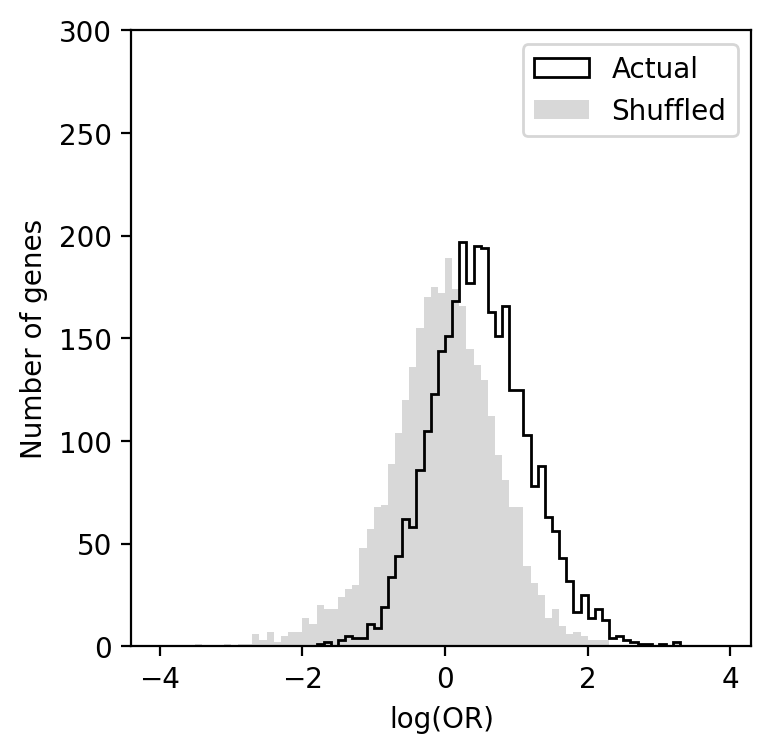

In [52]:
plt.figure(figsize=(4,4))
plt.hist(pdata["This Cell"],bins=np.arange(-4,4,0.1),alpha=1,label="Actual",histtype="step",color="black")
plt.hist(pdata["Next Cell"],bins=np.arange(-4,4,0.1),alpha=0.3,label="Shuffled",color="grey")
plt.legend()
plt.ylabel("Number of genes")
plt.xlabel("log(OR)")
plt.ylim(0,300)
plt.plot()
# save figure
plt.savefig('figures/co-expression_shuffledcellincc_hist.pdf', bbox_inches='tight')

In [ ]:
stats.wilcoxon(pdata["This Cell"],pdata["Next Cell"])

WilcoxonResult(statistic=784569.5, pvalue=8.802543287432799e-158)

In [68]:
# subset gene pairs in 2d clusters
acd2d_50k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/atac50kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
acd2d_50k.columns = ['chrom', 'start', 'end']

acd2d_50k_a = acd2d_50k.copy()
acd2d_50k_a['chrom'] = acd2d_50k_a['chrom'] + 'a'
acd2d_50k_b = acd2d_50k.copy()
acd2d_50k_b['chrom'] = acd2d_50k_b['chrom'] + 'b'
acd2d_50k = pd.concat([acd2d_50k_a, acd2d_50k_b], axis=0).reset_index(drop=True)

acd2d_50k = acd2d_50k.sort_values(['chrom', 'start']).reset_index(drop=True)
acd2d_50k['region_id'] = np.arange(len(acd2d_50k))  # 每行一个 ID

bed_by_chr = {
    chrom: sub[['start', 'end', 'region_id']].to_numpy()
    for chrom, sub in acd2d_50k.groupby('chrom')
}

def map_pos_to_region(df, chrom_col, pos_col):
    res = np.full(len(df), -1, dtype=int)

    chrom_vals = df[chrom_col].values
    pos_vals   = df[pos_col].values

    for chrom, arr in bed_by_chr.items():
        mask = (chrom_vals == chrom)
        if not mask.any():
            continue

        pos = pos_vals[mask]
        starts = arr[:, 0]
        ends   = arr[:, 1]
        rids   = arr[:, 2].astype(int)

        # 找到 start <= pos 的最后一个区间
        idx = np.searchsorted(starts, pos, side='right') - 1
        valid = (idx >= 0) & (pos <= ends[idx])

        tmp = np.full(len(pos), -1, dtype=int)
        tmp[valid] = rids[idx[valid]]

        res[mask] = tmp

    return pd.Series(res, index=df.index)

gene_pairs['region1'] = map_pos_to_region(gene_pairs, 'chrom1', 'pos1')
gene_pairs['region2'] = map_pos_to_region(gene_pairs, 'chrom2', 'pos2')
gene_pairs_same_interval = gene_pairs[(gene_pairs['region1'] != -1) & (gene_pairs['region1'] == gene_pairs['region2'])].copy()

In [69]:
gene_pairs_same_interval

,chrom1,pos1,name1,chrom2,pos2,name2,region1,region2
79,chr1a,181950000,2700078F05Rik,chr1a,181840000,Lbr,1549,1549
159,chr1a,132475000,6030442K20Rik,chr1a,132135000,Cdk18,1505,1505
160,chr1a,132475000,6030442K20Rik,chr1a,132415000,Dstyk,1505,1505
167,chr1a,132475000,6030442K20Rik,chr1a,132190000,Gm29695,1505,1505
172,chr1a,132475000,6030442K20Rik,chr1a,132190000,Lemd1,1505,1505
...,...,...,...,...,...,...,...,...
85035,chrXb,20920000,Syn1,chrXb,20960000,Uxt,3615,3615
85050,chrXb,7760000,Tfe3,chrXb,7720000,Wdr45,3609,3609
85063,chrXb,20655000,Uba1,chrXb,20700000,Usp11,3615,3615
85064,chrXb,20655000,Uba1,chrXb,20960000,Uxt,3615,3615


In [70]:

# filter pdata rows, keep only gene pairs in gene_pairs_same_interval
pdata_subset = pdata.reset_index().copy()
pdata_subset = pdata_subset.merge(gene_pairs_same_interval[['name1','name2']],on=['name1','name2'],how='inner').drop_duplicates()
pdata_subset

,name1,name2,This Cell,Next Cell
0,1110051M20Rik,Ckap5,0.929384,-0.049741
2,1600010M07Rik,Ipo7,0.455284,0.455284
4,1600010M07Rik,Wee1,-0.191755,0.333411
6,1810013L24Rik,Usp7,0.002310,0.002310
8,1810026B05Rik,AC099699.1,0.420757,0.140312
...,...,...,...,...
2134,Zfp568,Zfp74,-0.120294,-1.478834
2136,Zfp599,Zfp809,0.488372,-0.391072
2138,Zfp976,Zfp977,0.971644,0.971644
2140,Zkscan1,Zscan21,0.561286,-0.299344


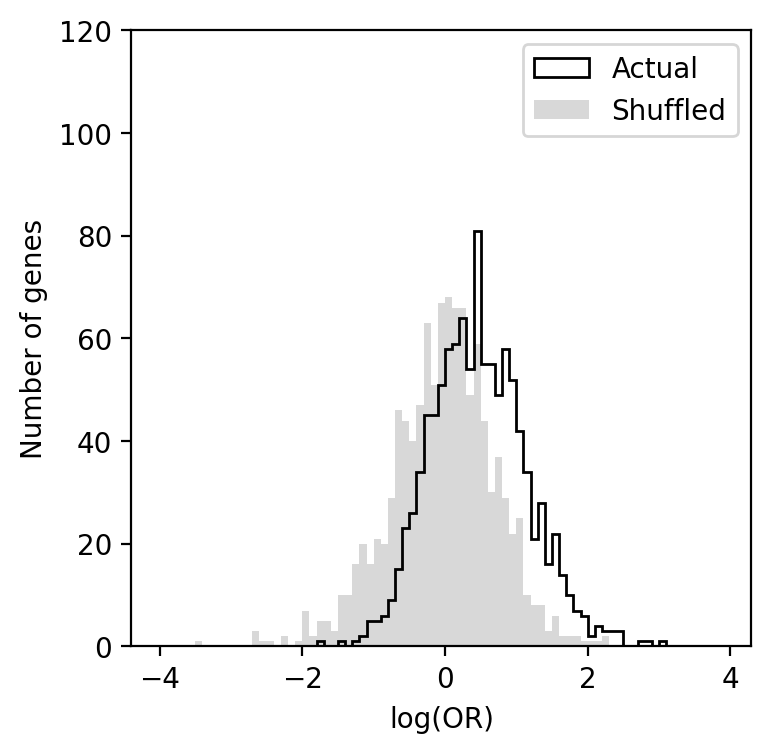

In [72]:
plt.figure(figsize=(4,4))
plt.hist(pdata_subset["This Cell"],bins=np.arange(-4,4,0.1),alpha=1,label="Actual",histtype="step",color="black")
plt.hist(pdata_subset["Next Cell"],bins=np.arange(-4,4,0.1),alpha=0.3,label="Shuffled",color="grey")
plt.legend()
plt.ylabel("Number of genes")
plt.xlabel("log(OR)")
plt.ylim(0,120)
plt.plot()
# save figure
plt.savefig('figures/co-expression_shuffledcellincc_hist.pdf', bbox_inches='tight')

In [67]:
print("Wilcoxon test p-value: ", stats.wilcoxon(pdata_subset["This Cell"],pdata_subset["Next Cell"]))

Wilcoxon test p-value:  WilcoxonResult(statistic=11778.0, pvalue=4.3426703578887736e-23)


In [78]:
tss[["name","tss"]]

,name,tss
3,0610010F05Rik,23633549
4,0610030E20Rik,72347334
6,0610040F04Rik,108660934
8,0610043K17Rik,101353783
12,1110002L01Rik,3427011
...,...,...
21194,Zxdc,90369494
21195,Zyg11a,108217922
21196,Zyg11b,108301096
21199,Zzz3,152396003


In [121]:
pdata_subset_dist = pdata_subset.merge(tss[["name","tss"]],left_on="name1",right_on="name",how="left").merge(tss[["name","tss"]],left_on="name2",right_on="name",how="left",suffixes=("_1","_2"))
pdata_subset_dist["dist"] = abs(pdata_subset_dist["tss_1"] - pdata_subset_dist["tss_2"])
print(pdata_subset_dist["dist"].median())

50390.5


In [120]:
pdata_dist = pdata.reset_index().merge(tss[["name","tss"]],left_on="name1",right_on="name",how="left").merge(tss[["name","tss"]],left_on="name2",right_on="name",how="left",suffixes=("_1","_2"))
pdata_dist["dist"] = abs(pdata_dist["tss_1"] - pdata_dist["tss_2"])
print(pdata_dist["dist"].median())

81085.0


Text(0, 0.5, 'Density of gene pair counts')

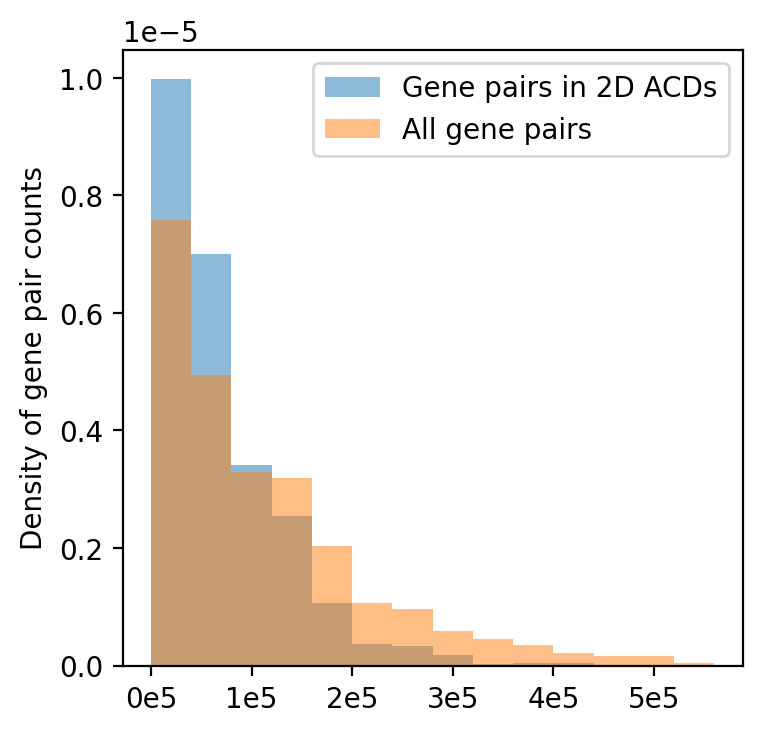

In [119]:
# histogram of distances
plt.figure(figsize=(4,4))

plt.hist(pdata_subset_dist["dist"],bins=np.arange(0,6e5,4e4),alpha=0.5,label="Gene pairs in 2D ACDs", density=True)
plt.hist(pdata_dist["dist"],bins=np.arange(0,6e5,4e4),alpha=0.5,label="All gene pairs", density=True)
# xtick use scientific notation
plt.xticks(np.arange(0,6e5,1e5), [f"{int(x/1e5)}e5" for x in np.arange(0,6e5,1e5)])

# density plot

plt.legend()
plt.ylabel("Density of gene pair counts")